# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Camden Wehrle, Christine Berlingeri, Sarah Bae

**ID**: cw566, cnb53, ssb238

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Roots")

  Activating project at `c:\Users\13158\Downloads`
    Updating registry at `C:\Users\13158\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\13158\Downloads\Project.toml`
  No Changes to `C:\Users\13158\Downloads\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\13158\Downloads\Project.toml`
  No Changes to `C:\Users\13158\Downloads\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\13158\Downloads\Project.toml`
  No Changes to `C:\Users\13158\Downloads\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\13158\Downloads\Project.toml`
  No Changes to `C:\Users\13158\Downloads\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\13158\Downloads\Project.toml`
  No Changes to `C:\Users\13158\Downloads\Manifest.toml`


In [3]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

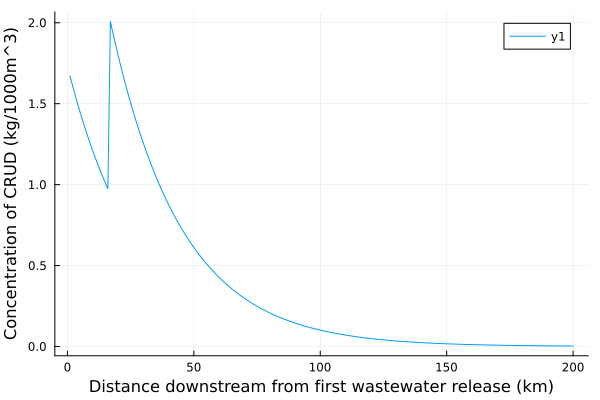

In [5]:

function conc_simulate_timestep(ccombine,velocity,k,distance)
    #Derive exponential decay formula (C = C0e^(-kt)) to be in terms of 
    #Distance and velocity rather than time
    return cnew = ccombine*exp(-k*(distance/velocity))
end

#Create a function to determine concentration at different distances down the river
function river_twobox_simulate(criver,c1,qriver,q1,c2,q2,velocity,k,initial_distance,final_distance,distance_step)
    #Initialize an output array of concentrations that can be analyzed or plotted
    array_length = Int(final_distance/distance_step)
    conc_output = zeros(array_length)
    distance = initial_distance
    #Mixing river and first waste stream input
    conc_output[1] = (criver*qriver + c1*q1)/(qriver+q1)
    #Iterate through many distance steps and find the concentration at each one
    #As the CRUD decays moving downstream
    for t = 1:array_length - 1
        #When the plug flow parcel reaches the second wastewater input, mix
        #The river concentration of CRUD with that of the wastewater
        #At all other distance steps, run a timestep to show CRUD decay
        if distance == 15
            conc_output[t+1] = (conc_output[t]*(qriver+q1) + c2*q2)/(qriver+q1+q2)
        else
            conc_output[t+1] = conc_simulate_timestep(conc_output[t],velocity,k,distance_step)
        end
        distance = distance + distance_step
    end
    return(conc_output)
end

#Define variables for model inputs (from the river diagram)
criver = .5 #kg/1000m^3
c1 = 9 #kg/1000m^3
c2 = 7 #kg/1000m^3
qriver = 250000 #m^3/d
q1 = 40000 #m^3/d
q2 = 60000 #m^3/d
velocity = 10 #km/d
k = .36 #d^-1
initial_distance= 0 #km
final_distance = 200 #km
distance_step = 1 #km

crud_conc = river_twobox_simulate(criver,c1,qriver,q1,c2,q2,velocity,k,initial_distance,final_distance,distance_step)

#Plot the CRUD concentration to see if the system complies with regulatory limit
plot(crud_conc)
xlabel!("Distance downstream from first wastewater release (km)")
ylabel!("Concentration of CRUD (kg/1000m^3)")


Yes, the system is actually in compliance with regulatory limits of 2.5kg/1000m^3 at every point in the river. We plotted the concentrations at each defined distance step and from the plot it is clear that the concentration of CRUD is below 2.5kg/1000m^3 at all points, even when the river mixes with waste streams. 

For this question, we took heavy influence from the lecture slides. We used the lecture from 9/16 to help us understand how to formulate the two box model and iterate over the time/distance steps. We used the slides from 9/18 to help compute the mixed concentration of CRUD at the wastewater inputs. 

Since we are looking downstream of the waste inputs but with no defined endpoint, we aimed to create a vector of CRUD concentrations at different distances from the first wastewater input. We decided to go to 200 kms since after that point the exponential decay will make the CRUD concentrations extremely low. 

The decay equation was used to write the function that was called at each distance step. The equation was:

$dC/dt = -kC$

Also, since we want to express this in terms of distance and not time, we can use this equation to replace the time term with distance and velocity:

$t= x/v$

Overall, the exponential decay equation used in the code is in the form:

$C = C_0e^(-k(x/v))$

The river_twobox_simulate function then can call the decay function at each time/distance step, mixing the concentration in the river with the concentration in the second waste stream when the parcel of water reaches that point. The output vector of CRUD concentrations was plotted in the end, so it could easily be seen if the regulatory limit was exceeded.

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

0.38196601125010543

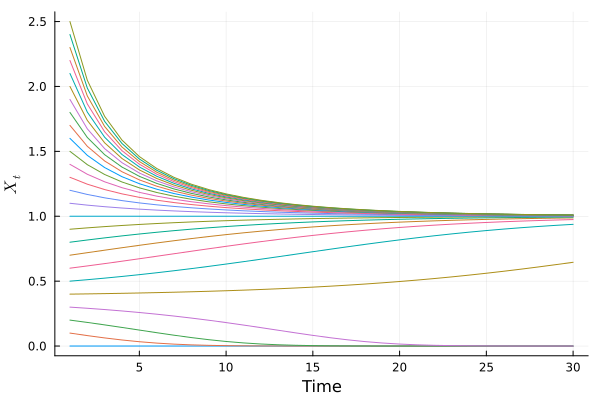

In [37]:
#Write the part of shallow lake model encompassing P recycle
function lake_P_cycling(x, q) 
    return x.^q ./ (1 .+ x.^q);
end
#Part of model encompassing P outflow
lake_P_out(x, b) = b .* x;

#Define a as a vector, where at = .02 for all time points
#Define other intial conditions
a = repeat([0],30)
b = .5
q = 1.5
T = 30
X_vals = collect(0.0:0.1:2.5)
#Simulate the lake model over all time steps, yielding the value of Xt at each step
function simulate_lake_P(X_ic, T, b, q, a, y)
   X = zeros(T)
   X[1] = X_ic
   for t = 2:T
       X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
   end
   return X
end
#Plot the initial conditions, allowing for an estimate of equilibria locations
X = map(x -> simulate_lake_P(x, T, 0.5, 1.5, zeros(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time")

#Put together functions to find change in phosphorus concentration
X_delta(x, a,q,b) = a .+ lake_P_cycling(x,q) .- lake_P_out(x,b)
xo = .2
#Find the roots given the equilibria guess xo
print(Roots.find_zero(x -> X_delta(x,a,q,b), xo))
return(p_noinflow)
 

We began this question by looking at the code given for the shallow lake model in class, and plotting that with the given initial conditions. From there, the equilibria could be seen to be about Xt = 1 and a bit above Xt = 0. Based off of that, we used xo = 1 when using the Roots.jl package. This yielded a root of 1.0, and the same root was obtained when testing it with xo = 1.2 and xo = .9. Also based off of the initial conditions plot, xo = .3 and xo = .2 were tested to find the second root. This yielded a root of .382. The system is quite stable, as little changes around the two equilibria still result in phosphorus concentrations returning to that equilibira. 

Afterwards, a was defined as a vector of the value .02, repeated 30 times. The graphs looked fairly similar, but finding the roots yielded values of 1.134, .154, and .116 for the equibria. There were actually three roots this time, the third root at .116 being found when xo was set to around .1 and lower. The dynamics and resiliency did not really change even when we added the point source release of phosphorus. There was still convergence around the values of Xt = 1 and Xt = 0, though those equilibria points did change a bit. 

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.